# Kernighan-Lin (KL) Partitioning Algorithm

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import random
plt.rcParams["figure.figsize"] = (15,12)

class Graph:
    def __init__(self):
        self.adj_list = []
        self.nodes = []
        self.num_nodes = 0
        self.node_affiliation = {}
        self.cxy = {}
        self.node_part = {}
    
    def addNode(self, node, affiliation='p1'):
        self.num_nodes += 1
        self.nodes.append(node)
        self.node_affiliation[node] = affiliation
        self.node_part[node] = [node]
    
    def delNode(self, nodes):
        for i in nodes:
            self.nodes.remove(i)

    def addEdge(self, a, b, w):
        if(a in self.nodes and b in self.nodes):
            t, l = (min(a,b), max(a,b))
            for i in range(len(self.adj_list)):
                if(self.adj_list[i][0] == t and self.adj_list[i][1] == l):
                    self.adj_list[i][2] += w
                    self.cxy[t+l] = self.adj_list[i][2]
                    return
            self.adj_list.append([t, l, w])
            self.cxy[t+l] = w
        else:
            print("This node is not declared")
    
    def consume_edge(self, edge):
        self.node_part[edge[0]] += self.node_part[edge[1]]
        self.nodes.remove(edge[1])
        weight_dicts = {}
        delete_indices  = []
        edges = self.adj_list

        for i in range(len(self.adj_list)):
            if(edges[i][0] == edge[1] and edges[i][1] != edge[0]):
                if(edges[i][1] in weight_dicts.keys()):
                    weight_dicts[edges[i][1]] += edges[i][2]
                else:
                    weight_dicts[edges[i][1]] = edges[i][2]
                delete_indices.append(i)
            elif(edges[i][1] == edge[1] and edges[i][0] != edge[0]):
                if(edges[i][0] in weight_dicts.keys()):
                    weight_dicts[edges[i][0]] += edges[i][2]
                else:
                    weight_dicts[edges[i][0]] = edges[i][2]
                delete_indices.append(i)
            elif(edges[i][1] == edge[1] and edges[i][0] == edge[0]):
                delete_indices.append(i)
            else:
                pass
        
        delete_indices.sort(reverse=True)
        for x in delete_indices:
            del self.adj_list[x]

        for p in weight_dicts.keys():
            self.addEdge(edge[0], p, weight_dicts[p])
        
        self.num_nodes = len(self.nodes)
    
    def get_heaviest_edge(self):
        sorted_edges = sorted(self.adj_list, key= lambda x: x[2], reverse=True)
        return sorted_edges[0] 
    
    def get_cost(self):
        cost = 0
        d = self.node_affiliation
        for i in self.adj_list:
            if(d[i[0]] != d[i[1]]):
                cost += i[2]
        return cost
    
    def IE(self, node):
        #(internal, external) cost of nodes
        internal, external = 0, 0
        d = self.node_affiliation
        p = d[node]
        for i in self.adj_list:
            if(i[0] == node):
                if(d[i[1]] != p):
                    external += i[2]
                else:
                    internal += i[2]
            elif(i[1] == node):
                if(d[i[0]] != p):
                    external += i[2]
                else:
                    internal += i[2]
            else:
                pass
        return (internal, external)
        
class GraphVisualizer:
    def __init__(self):
        self.G = nx.Graph()
        self.colors = {}
    
    def reset(self):
        self.G = nx.Graph()

    def addEdges(self, graph):
        self.graph = graph
        for i in graph.nodes:
            self.G.add_node(i)
        for i in graph.adj_list:
            self.G.add_edge(i[0], i[1], weight=i[2])
        
    def visualize(self, text="Network Visualized"):
        nodes = self.graph.nodes
        p = list(set(self.graph.node_affiliation.values()))
        
        partitions = []
    
        for k in p:
            partitions.append([i for i in nodes if self.graph.node_affiliation[i] == k])
            if k not in self.colors.keys():
                self.colors[k] = '#%06X' % random.randint(0, 0xFFFFFF)
            
        
        node_colors = [self.colors[self.graph.node_affiliation[n]] for n in list(self.G.nodes)]
        pos = nx.circular_layout(self.G)
        nx.draw_networkx(self.G, pos, node_color = node_colors)
        labels = nx.get_edge_attributes(self.G, 'weight')
        nx.draw_networkx_edge_labels(self.G, pos, edge_labels=labels)
        plt.title(text)
        
        legend_handles = []
        for i in p:
            legend_handles.append(mpatches.Patch(color=self.colors[i], label=i))
        plt.legend(handles=legend_handles)
        plt.show()

In [2]:
def kerninghan_lin(graph):
    """KL algorithm for partitioning into two equal partitions"""
    nodes = graph.nodes
    increments = []
    prefix = [0]
    swaps = []
    swapped = {}
    d = graph.node_affiliation

    sort_str = lambda x: ''.join(sorted(x))
    for i in nodes:
        swapped[i] = False
    
    n = len(nodes)//2
    first = True

    I, E, D = {},{},{}
    
    for i in range(n):
        newnodes = [i for i in nodes if not swapped[i]]
        p1 = [i for i in newnodes if graph.node_affiliation[i] == 'P1']
        p2 = [i for i in newnodes if i not in p1]
        p1.sort()
        p2.sort()
        
        G = {}
        for i in newnodes:
            if first:
                I[i],E[i] = graph.IE(i)
                D[i] = E[i] - I[i]
            else:
                x = swaps[len(swaps) - 1]
                s1,s2 = sort_str(i+x[0]), sort_str(i+x[1])
                if(d[x[0]] == d[i]):
                    D[i] = D[i] + (2*graph.cxy.get(s1, 0) - 2*graph.cxy.get(s2, 0))
                else:
                    D[i] = D[i] - (2*graph.cxy.get(s1, 0) - 2*graph.cxy.get(s2, 0))
        if first:
            first = False
        
        for i in p1:
            for j in p2:
                G[i+j] = D[i] + D[j] - 2*graph.cxy.get(i+j, 0)
        
        swap = max(G, key=G.get)
        increments.append(G[swap])
        swaps.append(swap)

        swapped[swap[0]] = True
        swapped[swap[1]] = True
    
    for i in range(len(increments)):
        prefix.append(increments[i] + prefix[i])
    
    maxim_ind = np.argmax(prefix)
    return (swaps, maxim_ind-1)

In [3]:
import string

def kerninghan_lin_generic(graph, show=True):
    """Modified KL algorithm which adds difference number of dummy nodes
       in order to perform partitioning into unequal partitions"""
    nodes = graph.nodes

    n1 = len([i for i in nodes if graph.node_affiliation[i] == 'P1'])
    n2 = len(nodes) - n1

    addednodes = []

    if(n2 > n1):
        for i in range(n2-n1):
            x = [i for i in string.ascii_letters if i not in nodes][0]
            graph.addNode(x,'P1')
            addednodes.append(x)
    else:
        for i in range(n1-n2):
            x = [i for i in string.ascii_letters if i not in nodes][0]
            graph.addNode(x,'P2')
            addednodes.append(x)
    
    if show:
        print(addednodes,"were the nodes added")
    
    swaps,m = kerninghan_lin(graph)
    return (swaps, m, addednodes)

In [4]:
v = GraphVisualizer()

In [5]:
import matplotlib.pyplot as plt
import networkx as nx
import random


def generate_benchmark(n=26, seed=20160):
    #n is number of nodes
    random.seed(seed)
    G = nx.erdos_renyi_graph(n, 0.5, seed=seed)

    for edge in G.edges():
        wt = random.randint(1,7)
        G[edge[0]][edge[1]]['weight'] = wt

    return G

def plot_benchmark(G, showedgewt = False): 
    pos = nx.spring_layout(G) 
    nx.draw_networkx(G, pos=pos, node_size=30, width=0.7)
    if showedgewt:
        labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8)
    plt.show()

def convert_to_our_graph(G, init_partition):
    hasher = lambda x : chr(list(G.nodes())[x] + 65) 
    graph = Graph()
    
    for i in range(len(G.nodes())):
        graph.addNode(hasher(i), init_partition[i])
    
    for edge in G.edges():
        graph.addEdge(hasher(edge[0]), hasher(edge[1]), G[edge[0]][edge[1]]['weight'])
    
    return graph

def init_partition_generator(m, n):
    return ['P1']*m + ['P2']*n  


### KL partitioning visualized for partitioning into two equal partitions

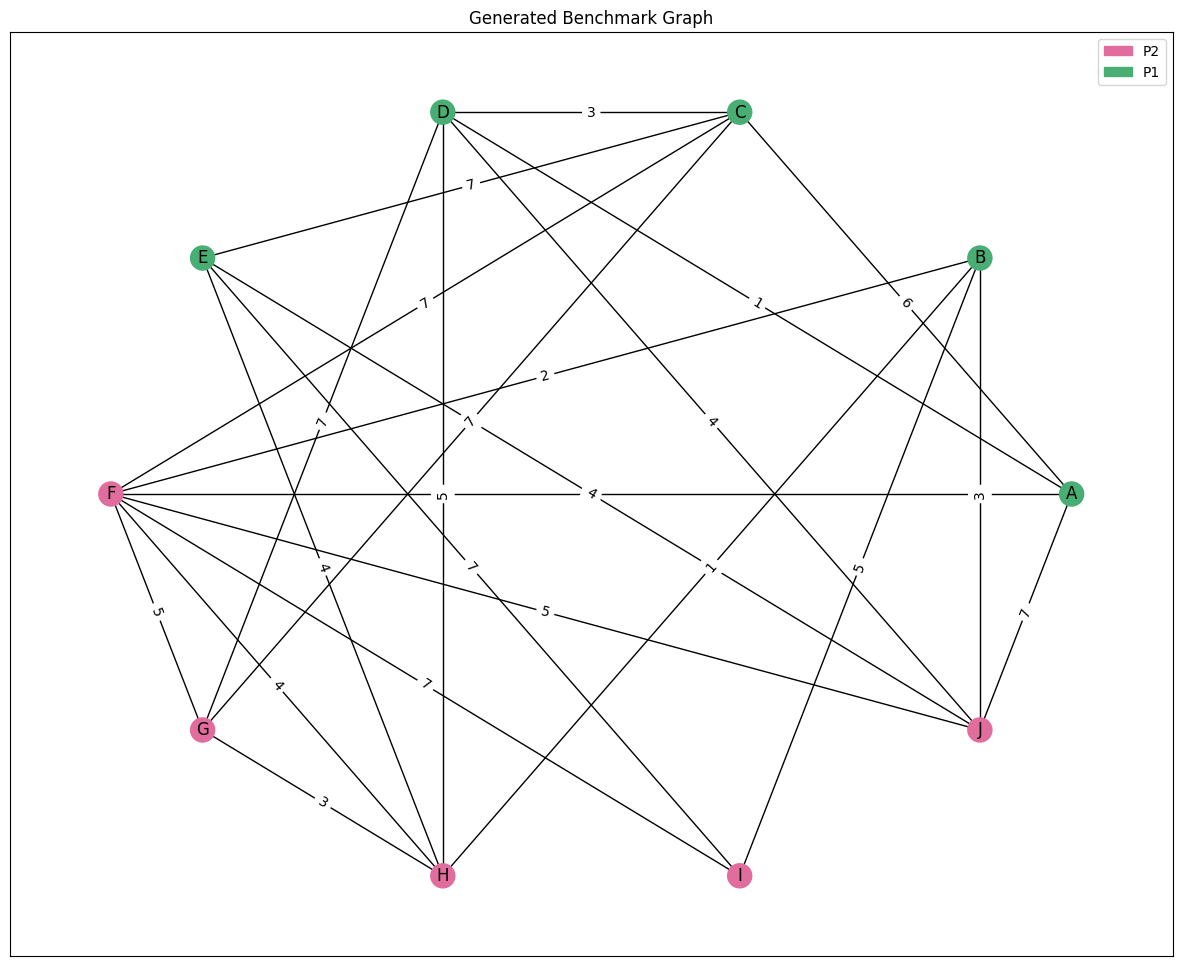

In [6]:
g = generate_benchmark(10, seed = 69)

graph = convert_to_our_graph(g, init_partition_generator(5,5))
v.addEdges(graph)
v.visualize("Generated Benchmark Graph")

In [7]:
swaps,m = kerninghan_lin(graph)

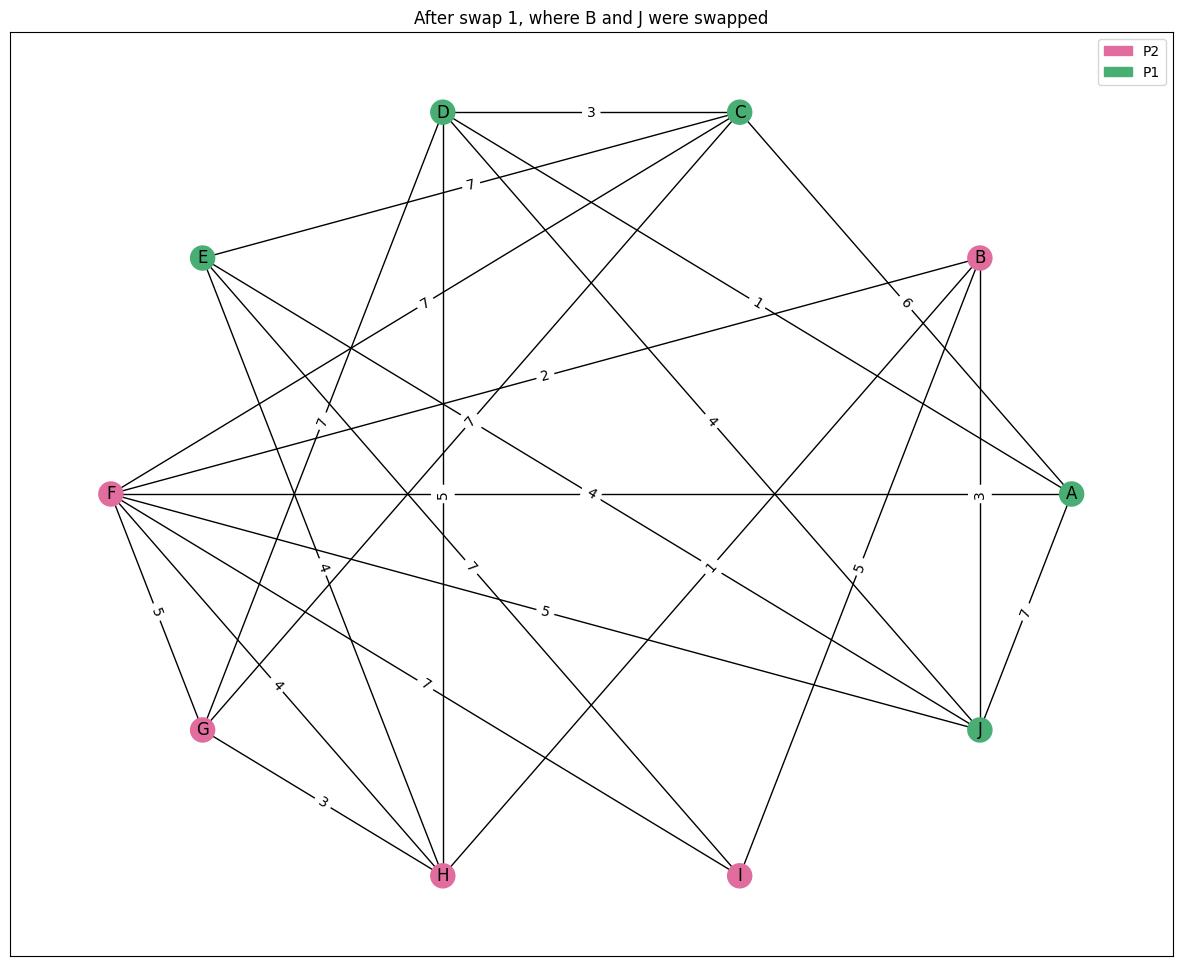

The new cut size (partitioning cost) is 46


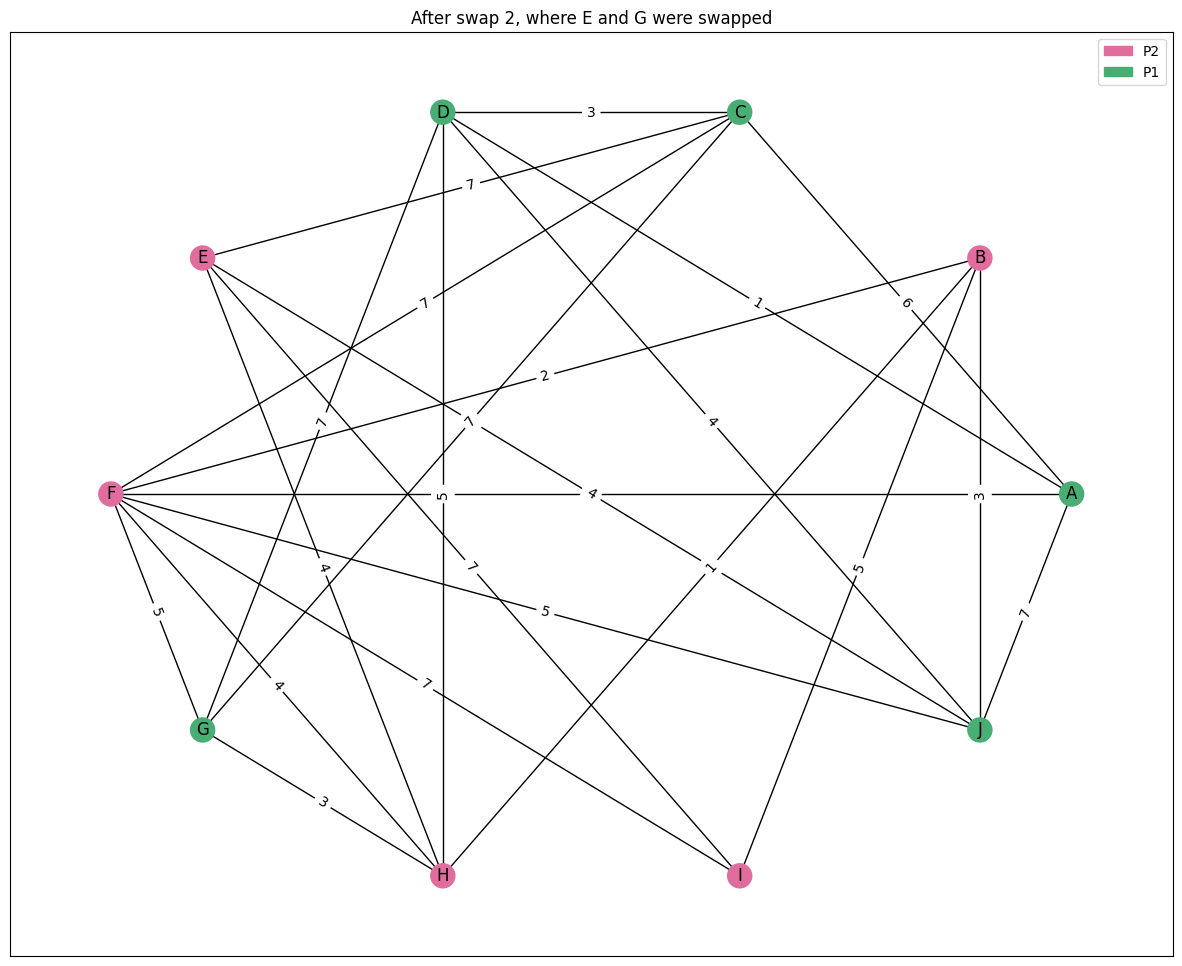

The new cut size (partitioning cost) is 40


In [8]:
k = 0
while(k <= m):
    p = swaps[k]
    graph.node_affiliation[p[0]], graph.node_affiliation[p[1]] = graph.node_affiliation[p[1]], graph.node_affiliation[p[0]]
    v.reset()
    v.addEdges(graph)
    v.visualize(f"After swap {k+1}, where {p[0]} and {p[1]} were swapped")
    print("The new cut size (partitioning cost) is",graph.get_cost())
    k += 1

### KL partitioning visualized for partitioning into two non equal partitions

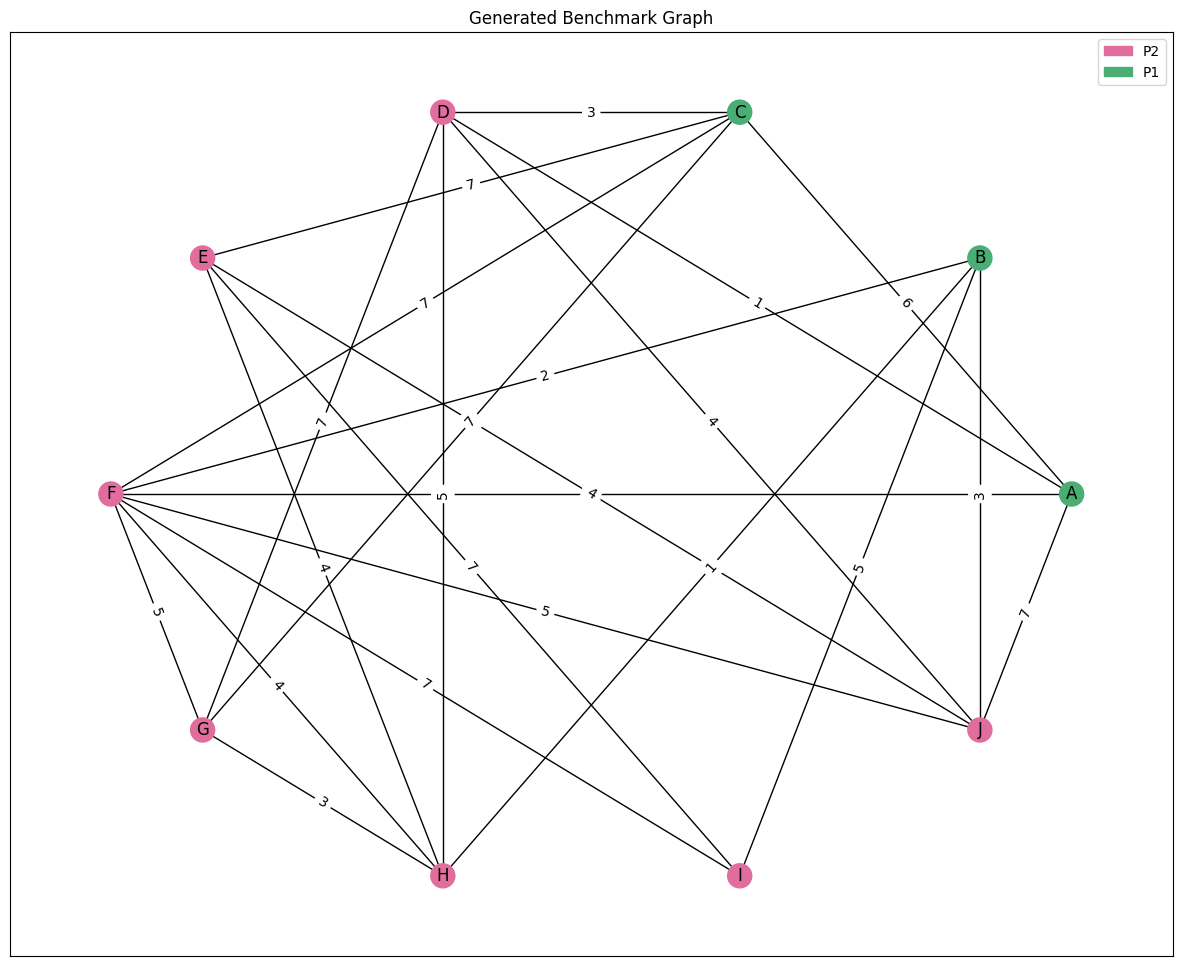

In [9]:
graph = convert_to_our_graph(g, init_partition_generator(3,7))
v.addEdges(graph)
v.visualize("Generated Benchmark Graph")

In [10]:
swaps, m, addednodes = kerninghan_lin_generic(graph)

['a', 'b', 'c', 'd'] were the nodes added


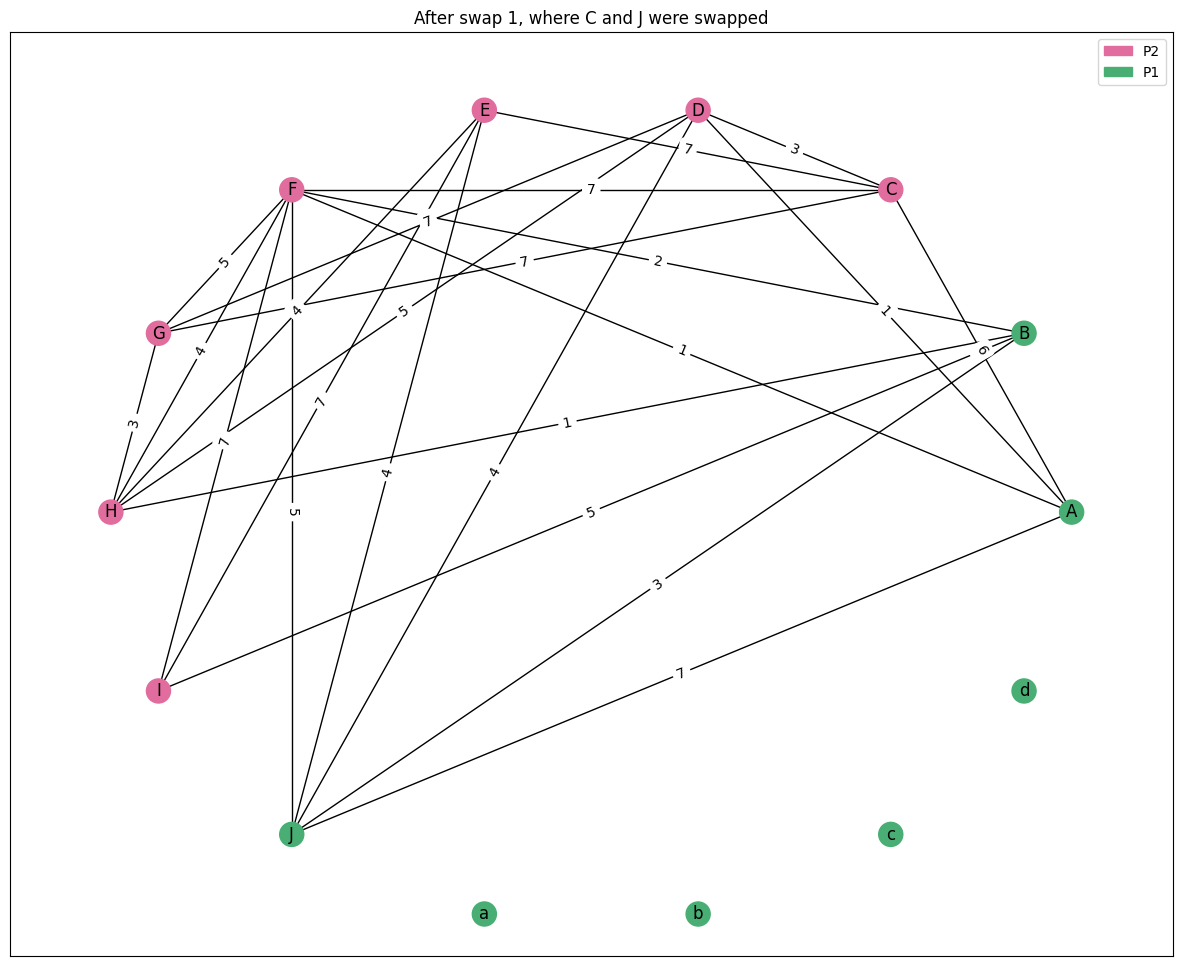

The new cut size (partitioning cost) is 29


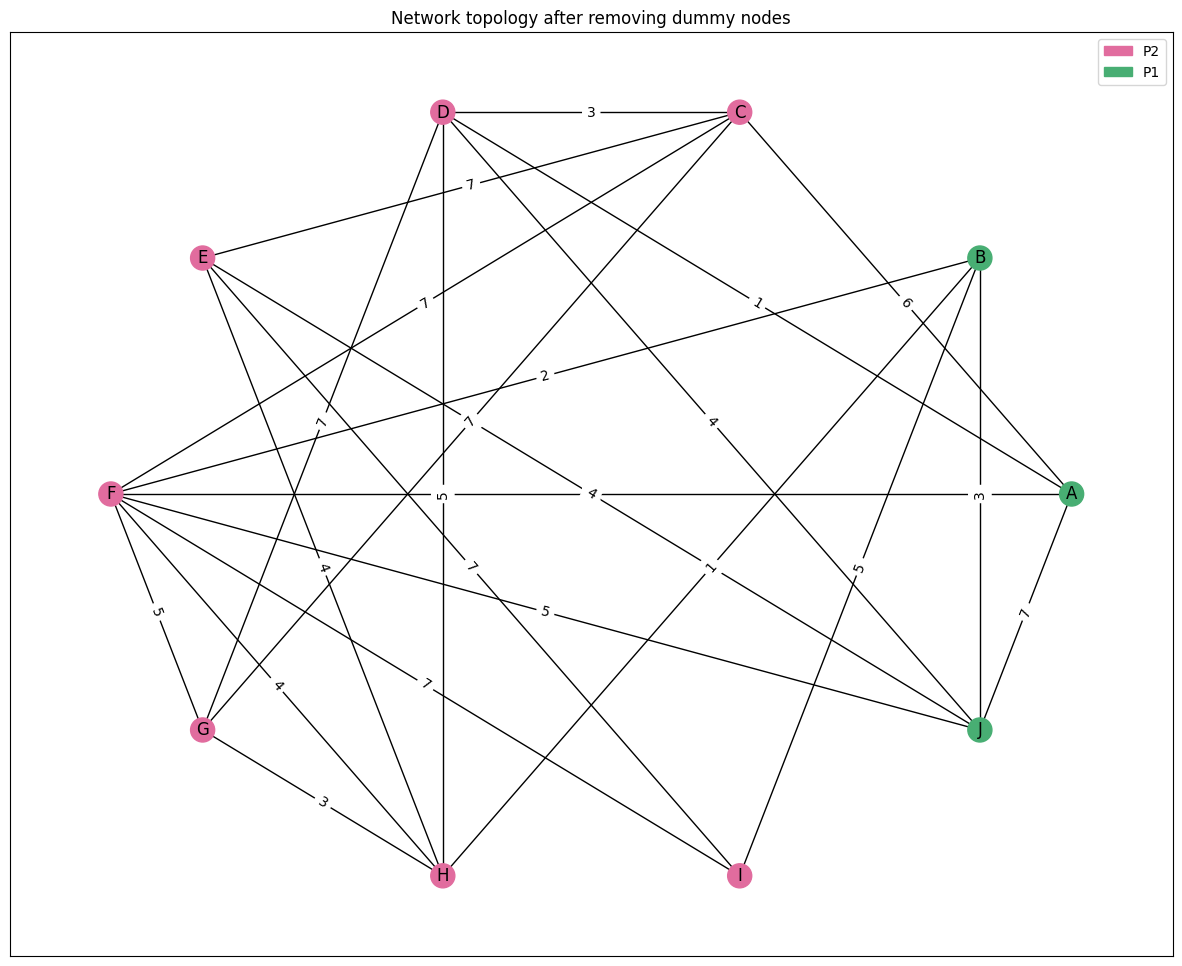

In [11]:
k = 0
while(k <= m):
    p = swaps[k]
    graph.node_affiliation[p[0]], graph.node_affiliation[p[1]] = graph.node_affiliation[p[1]], graph.node_affiliation[p[0]]
    v.reset()
    v.addEdges(graph)
    v.visualize(f"After swap {k+1}, where {p[0]} and {p[1]} were swapped")
    print("The new cut size (partitioning cost) is",graph.get_cost())
    k += 1

for x in addednodes:
    graph.delNode(x)

v.reset()
v.addEdges(graph)
v.visualize(f"Network topology after removing dummy nodes")

### To find the tabulate most optimized partition for all of the possible configurations of partition sizes

In [12]:
def kerninghan_lin_overall(g, show=True):
    partitions = {"Initial P1":[], "Initial P2":[], "Final P1":[], "Final P2":[], "length(Pi)":[], "length(Pf)":[], "Cutsize" : [], "Ratio Cut" : []}
    num_nodes = len(g.nodes())
    for i in range(1,num_nodes):
        graph = convert_to_our_graph(g, init_partition_generator(i,num_nodes-i))

        ip1 = [k for k in graph.nodes if graph.node_affiliation[k] == 'P1']
        ip2 = [k for k in graph.nodes if k not in ip1]

        swaps, m, addednodes = kerninghan_lin_generic(graph, show=show)
        k = 0
        while(k <= m):
            p = swaps[k]
            graph.node_affiliation[p[0]], graph.node_affiliation[p[1]] = graph.node_affiliation[p[1]], graph.node_affiliation[p[0]]
            k += 1

        for x in addednodes:
            graph.delNode(x)

        p1 = [k for k in graph.nodes if graph.node_affiliation[k] == 'P1']
        p2 = [k for k in graph.nodes if k not in p1]   

        partitions['Initial P1'].append(ip1)
        partitions['Initial P2'].append(ip2)
        partitions["Cutsize"].append(graph.get_cost())
        partitions["Ratio Cut"].append(graph.get_cost()/(i*(num_nodes-i)))
        partitions["Final P1"].append(p1)
        partitions["Final P2"].append(p2)
        partitions["length(Pi)"].append([len(ip1), len(ip2)])
        partitions["length(Pf)"].append([len(p1), len(p2)])
    
    return partitions         

In [13]:
import pandas as pd
g = generate_benchmark(10, seed = 69)
result = pd.DataFrame(kerninghan_lin_overall(g))

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'] were the nodes added
['a', 'b', 'c', 'd', 'e', 'f'] were the nodes added
['a', 'b', 'c', 'd'] were the nodes added
['a', 'b'] were the nodes added
[] were the nodes added
['a', 'b'] were the nodes added
['a', 'b', 'c', 'd'] were the nodes added
['a', 'b', 'c', 'd', 'e', 'f'] were the nodes added
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'] were the nodes added


In [14]:
display(result)

,Initial P1,Initial P2,Final P1,Final P2,length(Pi),length(Pf),Cutsize,Ratio Cut
0,[A],"[B, C, D, E, F, G, H, I, J]",[B],"[A, C, D, E, F, G, H, I, J]","[1, 9]","[1, 9]",11,1.222222
1,"[A, B]","[C, D, E, F, G, H, I, J]","[B, I]","[A, C, D, E, F, G, H, J]","[2, 8]","[2, 8]",20,1.250000
2,"[A, B, C]","[D, E, F, G, H, I, J]","[A, B, J]","[C, D, E, F, G, H, I]","[3, 7]","[3, 7]",29,1.380952
3,"[A, B, C, D]","[E, F, G, H, I, J]","[C, D, F, G, H]","[A, B, E, I, J]","[4, 6]","[5, 5]",38,1.583333
4,"[A, B, C, D, E]","[F, G, H, I, J]","[A, C, D, G, J]","[B, E, F, H, I]","[5, 5]","[5, 5]",40,1.600000
5,"[A, B, C, D, E, F]","[G, H, I, J]","[A, C, E, F, I, J]","[B, D, G, H]","[6, 4]","[6, 4]",38,1.583333
6,"[A, B, C, D, E, F, G]","[H, I, J]","[A, C, D, F, G, H, J]","[B, E, I]","[7, 3]","[7, 3]",28,1.333333
7,"[A, B, C, D, E, F, G, H]","[I, J]","[A, C, D, E, F, G, H, J]","[B, I]","[8, 2]","[8, 2]",20,1.250000
8,"[A, B, C, D, E, F, G, H, I]",[J],"[A, C, D, E, F, G, H, I, J]",[B],"[9, 1]","[9, 1]",11,1.222222


# Analysis of this method of Partitioning

To analyse this algorithm, we perform the following, we shall take 15 different networks of increasing sizes, which we shall use to compare the various algorithms, and tabulate for each example

In [15]:
results = {}
for i in range(10, 26):
    g = generate_benchmark(i, seed = 440+i)
    results[i] = pd.DataFrame(kerninghan_lin_overall(g, show=False))

Here are the results 

In [16]:
for i in results.keys():
    print(f"For the benchmark graph with {i} nodes, here is the tabulated results")
    display(results[i])

For the benchmark graph with 10 nodes, here is the tabulated results


,Initial P1,Initial P2,Final P1,Final P2,length(Pi),length(Pf),Cutsize,Ratio Cut
0,[A],"[B, C, D, E, F, G, H, I, J]","[A, E]","[B, C, D, F, G, H, I, J]","[1, 9]","[2, 8]",4,0.444444
1,"[A, B]","[C, D, E, F, G, H, I, J]","[A, E]","[B, C, D, F, G, H, I, J]","[2, 8]","[2, 8]",4,0.250000
2,"[A, B, C]","[D, E, F, G, H, I, J]","[A, E, H]","[B, C, D, F, G, I, J]","[3, 7]","[3, 7]",11,0.523810
3,"[A, B, C, D]","[E, F, G, H, I, J]","[A, D, E, H]","[B, C, F, G, I, J]","[4, 6]","[4, 6]",11,0.458333
4,"[A, B, C, D, E]","[F, G, H, I, J]","[A, D, E, H, J]","[B, C, F, G, I]","[5, 5]","[5, 5]",16,0.640000
5,"[A, B, C, D, E, F]","[G, H, I, J]","[B, C, F, G, I, J]","[A, D, E, H]","[6, 4]","[6, 4]",11,0.458333
6,"[A, B, C, D, E, F, G]","[H, I, J]","[B, C, F, G, I, J]","[A, D, E, H]","[7, 3]","[6, 4]",11,0.523810
7,"[A, B, C, D, E, F, G, H]","[I, J]","[B, C, D, F, G, H, I, J]","[A, E]","[8, 2]","[8, 2]",4,0.250000
8,"[A, B, C, D, E, F, G, H, I]",[J],"[B, C, D, F, G, H, I, J]","[A, E]","[9, 1]","[8, 2]",4,0.444444


For the benchmark graph with 11 nodes, here is the tabulated results


,Initial P1,Initial P2,Final P1,Final P2,length(Pi),length(Pf),Cutsize,Ratio Cut
0,[A],"[B, C, D, E, F, G, H, I, J, K]",[C],"[A, B, D, E, F, G, H, I, J, K]","[1, 10]","[1, 10]",9,0.900000
1,"[A, B]","[C, D, E, F, G, H, I, J, K]","[A, C]","[B, D, E, F, G, H, I, J, K]","[2, 9]","[2, 9]",20,1.111111
2,"[A, B, C]","[D, E, F, G, H, I, J, K]","[A, C, F]","[B, D, E, G, H, I, J, K]","[3, 8]","[3, 8]",25,1.041667
3,"[A, B, C, D]","[E, F, G, H, I, J, K]","[A, B, C, E, G, I, J]","[D, F, H, K]","[4, 7]","[7, 4]",25,0.892857
4,"[A, B, C, D, E]","[F, G, H, I, J, K]","[A, B, C, E, J]","[D, F, G, H, I, K]","[5, 6]","[5, 6]",28,0.933333
5,"[A, B, C, D, E, F]","[G, H, I, J, K]","[A, B, C, E, J]","[D, F, G, H, I, K]","[6, 5]","[5, 6]",28,0.933333
6,"[A, B, C, D, E, F, G]","[H, I, J, K]","[A, B, C, E, G, I, J]","[D, F, H, K]","[7, 4]","[7, 4]",25,0.892857
7,"[A, B, C, D, E, F, G, H]","[I, J, K]","[B, D, E, G, H, I, J, K]","[A, C, F]","[8, 3]","[8, 3]",25,1.041667
8,"[A, B, C, D, E, F, G, H, I]","[J, K]","[A, C, D, F, G, H, I, K]","[B, E, J]","[9, 2]","[8, 3]",22,1.222222
9,"[A, B, C, D, E, F, G, H, I, J]",[K],"[A, B, D, E, F, G, H, I, J, K]",[C],"[10, 1]","[10, 1]",9,0.900000


For the benchmark graph with 12 nodes, here is the tabulated results


,Initial P1,Initial P2,Final P1,Final P2,length(Pi),length(Pf),Cutsize,Ratio Cut
0,[A],"[B, C, D, E, F, G, H, I, J, K, L]",[C],"[A, B, D, E, F, G, H, I, J, K, L]","[1, 11]","[1, 11]",10,0.909091
1,"[A, B]","[C, D, E, F, G, H, I, J, K, L]","[A, F]","[B, C, D, E, G, H, I, J, K, L]","[2, 10]","[2, 10]",20,1.000000
2,"[A, B, C]","[D, E, F, G, H, I, J, K, L]","[A, F, H]","[B, C, D, E, G, I, J, K, L]","[3, 9]","[3, 9]",24,0.888889
3,"[A, B, C, D]","[E, F, G, H, I, J, K, L]","[A, E, F, H]","[B, C, D, G, I, J, K, L]","[4, 8]","[4, 8]",29,0.906250
4,"[A, B, C, D, E]","[F, G, H, I, J, K, L]","[A, E, F, H, I]","[B, C, D, G, J, K, L]","[5, 7]","[5, 7]",32,0.914286
5,"[A, B, C, D, E, F]","[G, H, I, J, K, L]","[A, B, E, F, H, I]","[C, D, G, J, K, L]","[6, 6]","[6, 6]",34,0.944444
6,"[A, B, C, D, E, F, G]","[H, I, J, K, L]","[A, E, F, H, I]","[B, C, D, G, J, K, L]","[7, 5]","[5, 7]",32,0.914286
7,"[A, B, C, D, E, F, G, H]","[I, J, K, L]","[A, E, F, H, I]","[B, C, D, G, J, K, L]","[8, 4]","[5, 7]",32,1.000000
8,"[A, B, C, D, E, F, G, H, I]","[J, K, L]","[B, D, E, G, H, I, J, K, L]","[A, C, F]","[9, 3]","[9, 3]",30,1.111111
9,"[A, B, C, D, E, F, G, H, I, J]","[K, L]","[A, B, D, E, F, G, H, I, J, K]","[C, L]","[10, 2]","[10, 2]",23,1.150000


For the benchmark graph with 13 nodes, here is the tabulated results


,Initial P1,Initial P2,Final P1,Final P2,length(Pi),length(Pf),Cutsize,Ratio Cut
0,[A],"[B, C, D, E, F, G, H, I, J, K, L, M]",[F],"[A, B, C, D, E, G, H, I, J, K, L, M]","[1, 12]","[1, 12]",16,1.333333
1,"[A, B]","[C, D, E, F, G, H, I, J, K, L, M]","[E, L]","[A, B, C, D, F, G, H, I, J, K, M]","[2, 11]","[2, 11]",29,1.318182
2,"[A, B, C]","[D, E, F, G, H, I, J, K, L, M]","[A, E, L]","[B, C, D, F, G, H, I, J, K, M]","[3, 10]","[3, 10]",42,1.400000
3,"[A, B, C, D]","[E, F, G, H, I, J, K, L, M]","[C, D, J, M]","[A, B, E, F, G, H, I, K, L]","[4, 9]","[4, 9]",49,1.361111
4,"[A, B, C, D, E]","[F, G, H, I, J, K, L, M]","[A, B, C, E, H, J]","[D, F, G, I, K, L, M]","[5, 8]","[6, 7]",59,1.475000
5,"[A, B, C, D, E, F]","[G, H, I, J, K, L, M]","[A, B, C, E, H, J]","[D, F, G, I, K, L, M]","[6, 7]","[6, 7]",59,1.404762
6,"[A, B, C, D, E, F, G]","[H, I, J, K, L, M]","[A, B, C, E, H, J]","[D, F, G, I, K, L, M]","[7, 6]","[6, 7]",59,1.404762
7,"[A, B, C, D, E, F, G, H]","[I, J, K, L, M]","[A, B, C, D, H, J, K, M]","[E, F, G, I, L]","[8, 5]","[8, 5]",48,1.200000
8,"[A, B, C, D, E, F, G, H, I]","[J, K, L, M]","[A, B, E, F, G, H, I, K, L]","[C, D, J, M]","[9, 4]","[9, 4]",49,1.361111
9,"[A, B, C, D, E, F, G, H, I, J]","[K, L, M]","[B, C, D, F, G, H, I, J, K, M]","[A, E, L]","[10, 3]","[10, 3]",42,1.400000


For the benchmark graph with 14 nodes, here is the tabulated results


,Initial P1,Initial P2,Final P1,Final P2,length(Pi),length(Pf),Cutsize,Ratio Cut
0,[A],"[B, C, D, E, F, G, H, I, J, K, L, M, N]",[C],"[A, B, D, E, F, G, H, I, J, K, L, M, N]","[1, 13]","[1, 13]",14,1.076923
1,"[A, B]","[C, D, E, F, G, H, I, J, K, L, M, N]","[H, N]","[A, B, C, D, E, F, G, I, J, K, L, M]","[2, 12]","[2, 12]",26,1.083333
2,"[A, B, C]","[D, E, F, G, H, I, J, K, L, M, N]","[B, H, K]","[A, C, D, E, F, G, I, J, L, M, N]","[3, 11]","[3, 11]",30,0.909091
3,"[A, B, C, D]","[E, F, G, H, I, J, K, L, M, N]","[D, G, L, M]","[A, B, C, E, F, H, I, J, K, N]","[4, 10]","[4, 10]",37,0.925000
4,"[A, B, C, D, E]","[F, G, H, I, J, K, L, M, N]","[A, C, E, F, I, L]","[B, D, G, H, J, K, M, N]","[5, 9]","[6, 8]",43,0.955556
5,"[A, B, C, D, E, F]","[G, H, I, J, K, L, M, N]","[A, C, E, F, I, L]","[B, D, G, H, J, K, M, N]","[6, 8]","[6, 8]",43,0.895833
6,"[A, B, C, D, E, F, G]","[H, I, J, K, L, M, N]","[A, C, E, F, I, J, L]","[B, D, G, H, K, M, N]","[7, 7]","[7, 7]",43,0.877551
7,"[A, B, C, D, E, F, G, H]","[I, J, K, L, M, N]","[A, B, D, G, H, K, L, M]","[C, E, F, I, J, N]","[8, 6]","[8, 6]",48,1.000000
8,"[A, B, C, D, E, F, G, H, I]","[J, K, L, M, N]","[A, B, E, F, H, I, J, K, N]","[C, D, G, L, M]","[9, 5]","[9, 5]",39,0.866667
9,"[A, B, C, D, E, F, G, H, I, J]","[K, L, M, N]","[B, H, K, N]","[A, C, D, E, F, G, I, J, L, M]","[10, 4]","[4, 10]",35,0.875000


For the benchmark graph with 15 nodes, here is the tabulated results


,Initial P1,Initial P2,Final P1,Final P2,length(Pi),length(Pf),Cutsize,Ratio Cut
0,[A],"[B, C, D, E, F, G, H, I, J, K, L, M, N, O]",[H],"[A, B, C, D, E, F, G, I, J, K, L, M, N, O]","[1, 14]","[1, 14]",11,0.785714
1,"[A, B]","[C, D, E, F, G, H, I, J, K, L, M, N, O]","[C, H]","[A, B, D, E, F, G, I, J, K, L, M, N, O]","[2, 13]","[2, 13]",29,1.115385
2,"[A, B, C]","[D, E, F, G, H, I, J, K, L, M, N, O]","[B, C, H]","[A, D, E, F, G, I, J, K, L, M, N, O]","[3, 12]","[3, 12]",40,1.111111
3,"[A, B, C, D]","[E, F, G, H, I, J, K, L, M, N, O]","[B, C, G, H]","[A, D, E, F, I, J, K, L, M, N, O]","[4, 11]","[4, 11]",50,1.136364
4,"[A, B, C, D, E]","[F, G, H, I, J, K, L, M, N, O]","[B, C, G, H, O]","[A, D, E, F, I, J, K, L, M, N]","[5, 10]","[5, 10]",63,1.260000
5,"[A, B, C, D, E, F]","[G, H, I, J, K, L, M, N, O]","[A, B, C, D, F, G, I, L, O]","[E, H, J, K, M, N]","[6, 9]","[9, 6]",63,1.166667
6,"[A, B, C, D, E, F, G]","[H, I, J, K, L, M, N, O]","[A, B, C, D, F, G, O]","[E, H, I, J, K, L, M, N]","[7, 8]","[7, 8]",66,1.178571
7,"[A, B, C, D, E, F, G, H]","[I, J, K, L, M, N, O]","[A, B, C, D, F, G, I, L]","[E, H, J, K, M, N, O]","[8, 7]","[8, 7]",66,1.178571
8,"[A, B, C, D, E, F, G, H, I]","[J, K, L, M, N, O]","[A, B, C, D, G, I, J, K, L]","[E, F, H, M, N, O]","[9, 6]","[9, 6]",60,1.111111
9,"[A, B, C, D, E, F, G, H, I, J]","[K, L, M, N, O]","[A, B, C, D, F, G, I, J, K, L]","[E, H, M, N, O]","[10, 5]","[10, 5]",47,0.940000


For the benchmark graph with 16 nodes, here is the tabulated results


,Initial P1,Initial P2,Final P1,Final P2,length(Pi),length(Pf),Cutsize,Ratio Cut
0,[A],"[B, C, D, E, F, G, H, I, J, K, L, M, N, O, P]",[E],"[A, B, C, D, F, G, H, I, J, K, L, M, N, O, P]","[1, 15]","[1, 15]",16,1.066667
1,"[A, B]","[C, D, E, F, G, H, I, J, K, L, M, N, O, P]","[E, F]","[A, B, C, D, G, H, I, J, K, L, M, N, O, P]","[2, 14]","[2, 14]",27,0.964286
2,"[A, B, C]","[D, E, F, G, H, I, J, K, L, M, N, O, P]","[B, E, F]","[A, C, D, G, H, I, J, K, L, M, N, O, P]","[3, 13]","[3, 13]",42,1.076923
3,"[A, B, C, D]","[E, F, G, H, I, J, K, L, M, N, O, P]","[B, E, F, P]","[A, C, D, G, H, I, J, K, L, M, N, O]","[4, 12]","[4, 12]",55,1.145833
4,"[A, B, C, D, E]","[F, G, H, I, J, K, L, M, N, O, P]","[B, D, E, F, I]","[A, C, G, H, J, K, L, M, N, O, P]","[5, 11]","[5, 11]",69,1.254545
5,"[A, B, C, D, E, F]","[G, H, I, J, K, L, M, N, O, P]","[A, B, E, F, N, P]","[C, D, G, H, I, J, K, L, M, O]","[6, 10]","[6, 10]",67,1.116667
6,"[A, B, C, D, E, F, G]","[H, I, J, K, L, M, N, O, P]","[A, B, D, E, F, N, P]","[C, G, H, I, J, K, L, M, O]","[7, 9]","[7, 9]",71,1.126984
7,"[A, B, C, D, E, F, G, H]","[I, J, K, L, M, N, O, P]","[A, B, D, E, F, M, N, P]","[C, G, H, I, J, K, L, O]","[8, 8]","[8, 8]",73,1.140625
8,"[A, B, C, D, E, F, G, H, I]","[J, K, L, M, N, O, P]","[C, E, F, G, H, I, J, K, L]","[A, B, D, M, N, O, P]","[9, 7]","[9, 7]",77,1.222222
9,"[A, B, C, D, E, F, G, H, I, J]","[K, L, M, N, O, P]","[C, G, H, I, J, K, L, M, O]","[A, B, D, E, F, N, P]","[10, 6]","[9, 7]",71,1.183333


For the benchmark graph with 17 nodes, here is the tabulated results


,Initial P1,Initial P2,Final P1,Final P2,length(Pi),length(Pf),Cutsize,Ratio Cut
0,[A],"[B, C, D, E, F, G, H, I, J, K, L, M, N, O, P, Q]",[Q],"[A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, P]","[1, 16]","[1, 16]",14,0.875000
1,"[A, B]","[C, D, E, F, G, H, I, J, K, L, M, N, O, P, Q]","[B, N]","[A, C, D, E, F, G, H, I, J, K, L, M, O, P, Q]","[2, 15]","[2, 15]",34,1.133333
2,"[A, B, C]","[D, E, F, G, H, I, J, K, L, M, N, O, P, Q]","[B, N, Q]","[A, C, D, E, F, G, H, I, J, K, L, M, O, P]","[3, 14]","[3, 14]",48,1.142857
3,"[A, B, C, D]","[E, F, G, H, I, J, K, L, M, N, O, P, Q]","[B, M, N, Q]","[A, C, D, E, F, G, H, I, J, K, L, O, P]","[4, 13]","[4, 13]",64,1.230769
4,"[A, B, C, D, E]","[F, G, H, I, J, K, L, M, N, O, P, Q]","[A, B, M, N, Q]","[C, D, E, F, G, H, I, J, K, L, O, P]","[5, 12]","[5, 12]",82,1.366667
5,"[A, B, C, D, E, F]","[G, H, I, J, K, L, M, N, O, P, Q]","[B, C, H, K, M, Q]","[A, D, E, F, G, I, J, L, N, O, P]","[6, 11]","[6, 11]",91,1.378788
6,"[A, B, C, D, E, F, G]","[H, I, J, K, L, M, N, O, P, Q]","[D, F, G, J, L, O, Q]","[A, B, C, E, H, I, K, M, N, P]","[7, 10]","[7, 10]",92,1.314286
7,"[A, B, C, D, E, F, G, H]","[I, J, K, L, M, N, O, P, Q]","[B, C, E, H, K, M, N, Q]","[A, D, F, G, I, J, L, O, P]","[8, 9]","[8, 9]",94,1.305556
8,"[A, B, C, D, E, F, G, H, I]","[J, K, L, M, N, O, P, Q]","[B, C, D, H, J, K, N, P]","[A, E, F, G, I, L, M, O, Q]","[9, 8]","[8, 9]",105,1.458333
9,"[A, B, C, D, E, F, G, H, I, J]","[K, L, M, N, O, P, Q]","[A, D, F, G, I, J, L, N, O, P]","[B, C, E, H, K, M, Q]","[10, 7]","[10, 7]",92,1.314286


For the benchmark graph with 18 nodes, here is the tabulated results


,Initial P1,Initial P2,Final P1,Final P2,length(Pi),length(Pf),Cutsize,Ratio Cut
0,[A],"[B, C, D, E, F, G, H, I, J, K, L, M, N, O, P, ...",[N],"[A, B, C, D, E, F, G, H, I, J, K, L, M, O, P, ...","[1, 17]","[1, 17]",20,1.176471
1,"[A, B]","[C, D, E, F, G, H, I, J, K, L, M, N, O, P, Q, R]","[N, O]","[A, B, C, D, E, F, G, H, I, J, K, L, M, P, Q, R]","[2, 16]","[2, 16]",37,1.156250
2,"[A, B, C]","[D, E, F, G, H, I, J, K, L, M, N, O, P, Q, R]","[H, N, O]","[A, B, C, D, E, F, G, I, J, K, L, M, P, Q, R]","[3, 15]","[3, 15]",55,1.222222
3,"[A, B, C, D]","[E, F, G, H, I, J, K, L, M, N, O, P, Q, R]","[F, H, N, O]","[A, B, C, D, E, G, I, J, K, L, M, P, Q, R]","[4, 14]","[4, 14]",68,1.214286
4,"[A, B, C, D, E]","[F, G, H, I, J, K, L, M, N, O, P, Q, R]","[B, E, I, N, P]","[A, C, D, F, G, H, J, K, L, M, O, Q, R]","[5, 13]","[5, 13]",98,1.507692
5,"[A, B, C, D, E, F]","[G, H, I, J, K, L, M, N, O, P, Q, R]","[C, D, E, J, K, P]","[A, B, F, G, H, I, L, M, N, O, Q, R]","[6, 12]","[6, 12]",115,1.597222
6,"[A, B, C, D, E, F, G]","[H, I, J, K, L, M, N, O, P, Q, R]","[B, C, E, G, I, P, R]","[A, D, F, H, J, K, L, M, N, O, Q]","[7, 11]","[7, 11]",102,1.324675
7,"[A, B, C, D, E, F, G, H]","[I, J, K, L, M, N, O, P, Q, R]","[A, B, D, E, H, K, N, P]","[C, F, G, I, J, L, M, O, Q, R]","[8, 10]","[8, 10]",121,1.512500
8,"[A, B, C, D, E, F, G, H, I]","[J, K, L, M, N, O, P, Q, R]","[B, C, E, G, I, L, N, P, R]","[A, D, F, H, J, K, M, O, Q]","[9, 9]","[9, 9]",113,1.395062
9,"[A, B, C, D, E, F, G, H, I, J]","[K, L, M, N, O, P, Q, R]","[B, C, E, G, I, K, N, P, R]","[A, D, F, H, J, L, M, O, Q]","[10, 8]","[9, 9]",114,1.425000


For the benchmark graph with 19 nodes, here is the tabulated results


,Initial P1,Initial P2,Final P1,Final P2,length(Pi),length(Pf),Cutsize,Ratio Cut
0,[A],"[B, C, D, E, F, G, H, I, J, K, L, M, N, O, P, ...",[P],"[A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, ...","[1, 18]","[1, 18]",20,1.111111
1,"[A, B]","[C, D, E, F, G, H, I, J, K, L, M, N, O, P, Q, ...","[N, P]","[A, B, C, D, E, F, G, H, I, J, K, L, M, O, Q, ...","[2, 17]","[2, 17]",42,1.235294
2,"[A, B, C]","[D, E, F, G, H, I, J, K, L, M, N, O, P, Q, R, S]","[A, G, P]","[B, C, D, E, F, H, I, J, K, L, M, N, O, Q, R, S]","[3, 16]","[3, 16]",57,1.187500
3,"[A, B, C, D]","[E, F, G, H, I, J, K, L, M, N, O, P, Q, R, S]","[G, I, P, Q]","[A, B, C, D, E, F, H, J, K, L, M, N, O, R, S]","[4, 15]","[4, 15]",82,1.366667
4,"[A, B, C, D, E]","[F, G, H, I, J, K, L, M, N, O, P, Q, R, S]","[G, I, N, P, Q]","[A, B, C, D, E, F, H, J, K, L, M, O, R, S]","[5, 14]","[5, 14]",94,1.342857
5,"[A, B, C, D, E, F]","[G, H, I, J, K, L, M, N, O, P, Q, R, S]","[B, D, F, K, Q, S]","[A, C, E, G, H, I, J, L, M, N, O, P, R]","[6, 13]","[6, 13]",112,1.435897
6,"[A, B, C, D, E, F, G]","[H, I, J, K, L, M, N, O, P, Q, R, S]","[B, D, G, I, N, P, Q]","[A, C, E, F, H, J, K, L, M, O, R, S]","[7, 12]","[7, 12]",114,1.357143
7,"[A, B, C, D, E, F, G, H]","[I, J, K, L, M, N, O, P, Q, R, S]","[A, B, D, E, G, N, P, Q]","[C, F, H, I, J, K, L, M, O, R, S]","[8, 11]","[8, 11]",120,1.363636
8,"[A, B, C, D, E, F, G, H, I]","[J, K, L, M, N, O, P, Q, R, S]","[A, B, E, G, H, I, M, N, P]","[C, D, F, J, K, L, O, Q, R, S]","[9, 10]","[9, 10]",113,1.255556
9,"[A, B, C, D, E, F, G, H, I, J]","[K, L, M, N, O, P, Q, R, S]","[A, B, E, G, H, I, M, N, P]","[C, D, F, J, K, L, O, Q, R, S]","[10, 9]","[9, 10]",113,1.255556


For the benchmark graph with 20 nodes, here is the tabulated results


,Initial P1,Initial P2,Final P1,Final P2,length(Pi),length(Pf),Cutsize,Ratio Cut
0,[A],"[B, C, D, E, F, G, H, I, J, K, L, M, N, O, P, ...",[I],"[A, B, C, D, E, F, G, H, J, K, L, M, N, O, P, ...","[1, 19]","[1, 19]",22,1.157895
1,"[A, B]","[C, D, E, F, G, H, I, J, K, L, M, N, O, P, Q, ...","[I, K]","[A, B, C, D, E, F, G, H, J, L, M, N, O, P, Q, ...","[2, 18]","[2, 18]",42,1.166667
2,"[A, B, C]","[D, E, F, G, H, I, J, K, L, M, N, O, P, Q, R, ...","[A, G, R]","[B, C, D, E, F, H, I, J, K, L, M, N, O, P, Q, ...","[3, 17]","[3, 17]",74,1.450980
3,"[A, B, C, D]","[E, F, G, H, I, J, K, L, M, N, O, P, Q, R, S, T]","[C, D, J, M]","[A, B, E, F, G, H, I, K, L, N, O, P, Q, R, S, T]","[4, 16]","[4, 16]",92,1.437500
4,"[A, B, C, D, E]","[F, G, H, I, J, K, L, M, N, O, P, Q, R, S, T]","[C, D, G, J, M]","[A, B, E, F, H, I, K, L, N, O, P, Q, R, S, T]","[5, 15]","[5, 15]",101,1.346667
5,"[A, B, C, D, E, F]","[G, H, I, J, K, L, M, N, O, P, Q, R, S, T]","[A, B, F, G, I, R]","[C, D, E, H, J, K, L, M, N, O, P, Q, S, T]","[6, 14]","[6, 14]",114,1.357143
6,"[A, B, C, D, E, F, G]","[H, I, J, K, L, M, N, O, P, Q, R, S, T]","[A, C, D, G, J, M, R]","[B, E, F, H, I, K, L, N, O, P, Q, S, T]","[7, 13]","[7, 13]",112,1.230769
7,"[A, B, C, D, E, F, G, H]","[I, J, K, L, M, N, O, P, Q, R, S, T]","[A, C, D, G, J, M, O, R]","[B, E, F, H, I, K, L, N, P, Q, S, T]","[8, 12]","[8, 12]",120,1.250000
8,"[A, B, C, D, E, F, G, H, I]","[J, K, L, M, N, O, P, Q, R, S, T]","[A, B, E, F, G, I, K, Q, R]","[C, D, H, J, L, M, N, O, P, S, T]","[9, 11]","[9, 11]",136,1.373737
9,"[A, B, C, D, E, F, G, H, I, J]","[K, L, M, N, O, P, Q, R, S, T]","[A, B, C, D, F, G, I, J, M, R]","[E, H, K, L, N, O, P, Q, S, T]","[10, 10]","[10, 10]",136,1.360000


For the benchmark graph with 21 nodes, here is the tabulated results


,Initial P1,Initial P2,Final P1,Final P2,length(Pi),length(Pf),Cutsize,Ratio Cut
0,[A],"[B, C, D, E, F, G, H, I, J, K, L, M, N, O, P, ...",[G],"[A, B, C, D, E, F, H, I, J, K, L, M, N, O, P, ...","[1, 20]","[1, 20]",24,1.200000
1,"[A, B]","[C, D, E, F, G, H, I, J, K, L, M, N, O, P, Q, ...","[D, N]","[A, B, C, E, F, G, H, I, J, K, L, M, O, P, Q, ...","[2, 19]","[2, 19]",47,1.236842
2,"[A, B, C]","[D, E, F, G, H, I, J, K, L, M, N, O, P, Q, R, ...","[C, D, N]","[A, B, E, F, G, H, I, J, K, L, M, O, P, Q, R, ...","[3, 18]","[3, 18]",69,1.277778
3,"[A, B, C, D]","[E, F, G, H, I, J, K, L, M, N, O, P, Q, R, S, ...","[C, D, E, N]","[A, B, F, G, H, I, J, K, L, M, O, P, Q, R, S, ...","[4, 17]","[4, 17]",86,1.264706
4,"[A, B, C, D, E]","[F, G, H, I, J, K, L, M, N, O, P, Q, R, S, T, U]","[C, D, E, N, T]","[A, B, F, G, H, I, J, K, L, M, O, P, Q, R, S, U]","[5, 16]","[5, 16]",107,1.337500
5,"[A, B, C, D, E, F]","[G, H, I, J, K, L, M, N, O, P, Q, R, S, T, U]","[C, D, E, H, N, T]","[A, B, F, G, I, J, K, L, M, O, P, Q, R, S, U]","[6, 15]","[6, 15]",125,1.388889
6,"[A, B, C, D, E, F, G]","[H, I, J, K, L, M, N, O, P, Q, R, S, T, U]","[C, D, G, I, N, R, S]","[A, B, E, F, H, J, K, L, M, O, P, Q, T, U]","[7, 14]","[7, 14]",142,1.448980
7,"[A, B, C, D, E, F, G, H]","[I, J, K, L, M, N, O, P, Q, R, S, T, U]","[C, D, E, I, J, N, P, T]","[A, B, F, G, H, K, L, M, O, Q, R, S, U]","[8, 13]","[8, 13]",152,1.461538
8,"[A, B, C, D, E, F, G, H, I]","[J, K, L, M, N, O, P, Q, R, S, T, U]","[C, D, E, F, H, M, N, R, T]","[A, B, G, I, J, K, L, O, P, Q, S, U]","[9, 12]","[9, 12]",164,1.518519
9,"[A, B, C, D, E, F, G, H, I, J]","[K, L, M, N, O, P, Q, R, S, T, U]","[C, D, E, F, H, I, K, N, P, R, T]","[A, B, G, J, L, M, O, Q, S, U]","[10, 11]","[11, 10]",166,1.509091


For the benchmark graph with 22 nodes, here is the tabulated results


,Initial P1,Initial P2,Final P1,Final P2,length(Pi),length(Pf),Cutsize,Ratio Cut
0,[A],"[B, C, D, E, F, G, H, I, J, K, L, M, N, O, P, ...",[F],"[A, B, C, D, E, G, H, I, J, K, L, M, N, O, P, ...","[1, 21]","[1, 21]",30,1.428571
1,"[A, B]","[C, D, E, F, G, H, I, J, K, L, M, N, O, P, Q, ...","[A, M]","[B, C, D, E, F, G, H, I, J, K, L, N, O, P, Q, ...","[2, 20]","[2, 20]",58,1.450000
2,"[A, B, C]","[D, E, F, G, H, I, J, K, L, M, N, O, P, Q, R, ...","[A, C, H]","[B, D, E, F, G, I, J, K, L, M, N, O, P, Q, R, ...","[3, 19]","[3, 19]",87,1.526316
3,"[A, B, C, D]","[E, F, G, H, I, J, K, L, M, N, O, P, Q, R, S, ...","[A, C, D, H]","[B, E, F, G, I, J, K, L, M, N, O, P, Q, R, S, ...","[4, 18]","[4, 18]",102,1.416667
4,"[A, B, C, D, E]","[F, G, H, I, J, K, L, M, N, O, P, Q, R, S, T, ...","[A, C, D, H, M]","[B, E, F, G, I, J, K, L, N, O, P, Q, R, S, T, ...","[5, 17]","[5, 17]",127,1.494118
5,"[A, B, C, D, E, F]","[G, H, I, J, K, L, M, N, O, P, Q, R, S, T, U, V]","[A, C, D, F, H, U]","[B, E, G, I, J, K, L, M, N, O, P, Q, R, S, T, V]","[6, 16]","[6, 16]",141,1.468750
6,"[A, B, C, D, E, F, G]","[H, I, J, K, L, M, N, O, P, Q, R, S, T, U, V]","[A, C, F, H, I, J, U]","[B, D, E, G, K, L, M, N, O, P, Q, R, S, T, V]","[7, 15]","[7, 15]",156,1.485714
7,"[A, B, C, D, E, F, G, H]","[I, J, K, L, M, N, O, P, Q, R, S, T, U, V]","[F, I, J, L, M, R, S, U]","[A, B, C, D, E, G, H, K, N, O, P, Q, T, V]","[8, 14]","[8, 14]",158,1.410714
8,"[A, B, C, D, E, F, G, H, I]","[J, K, L, M, N, O, P, Q, R, S, T, U, V]","[A, C, D, F, H, I, J, P, U]","[B, E, G, K, L, M, N, O, Q, R, S, T, V]","[9, 13]","[9, 13]",182,1.555556
9,"[A, B, C, D, E, F, G, H, I, J]","[K, L, M, N, O, P, Q, R, S, T, U, V]","[A, C, D, H, I, J, M, P, S, U]","[B, E, F, G, K, L, N, O, Q, R, T, V]","[10, 12]","[10, 12]",191,1.591667


For the benchmark graph with 23 nodes, here is the tabulated results


,Initial P1,Initial P2,Final P1,Final P2,length(Pi),length(Pf),Cutsize,Ratio Cut
0,[A],"[B, C, D, E, F, G, H, I, J, K, L, M, N, O, P, ...",[F],"[A, B, C, D, E, G, H, I, J, K, L, M, N, O, P, ...","[1, 22]","[1, 22]",18,0.818182
1,"[A, B]","[C, D, E, F, G, H, I, J, K, L, M, N, O, P, Q, ...","[F, N]","[A, B, C, D, E, G, H, I, J, K, L, M, O, P, Q, ...","[2, 21]","[2, 21]",34,0.809524
2,"[A, B, C]","[D, E, F, G, H, I, J, K, L, M, N, O, P, Q, R, ...","[B, K, R]","[A, C, D, E, F, G, H, I, J, L, M, N, O, P, Q, ...","[3, 20]","[3, 20]",70,1.166667
3,"[A, B, C, D]","[E, F, G, H, I, J, K, L, M, N, O, P, Q, R, S, ...","[B, F, K, R]","[A, C, D, E, G, H, I, J, L, M, N, O, P, Q, S, ...","[4, 19]","[4, 19]",86,1.131579
4,"[A, B, C, D, E]","[F, G, H, I, J, K, L, M, N, O, P, Q, R, S, T, ...","[B, F, K, N, R]","[A, C, D, E, G, H, I, J, L, M, O, P, Q, S, T, ...","[5, 18]","[5, 18]",102,1.133333
5,"[A, B, C, D, E, F]","[G, H, I, J, K, L, M, N, O, P, Q, R, S, T, U, ...","[B, F, G, K, P, R]","[A, C, D, E, H, I, J, L, M, N, O, Q, S, T, U, ...","[6, 17]","[6, 17]",117,1.147059
6,"[A, B, C, D, E, F, G]","[H, I, J, K, L, M, N, O, P, Q, R, S, T, U, V, W]","[B, D, E, F, K, R, S]","[A, C, G, H, I, J, L, M, N, O, P, Q, T, U, V, W]","[7, 16]","[7, 16]",144,1.285714
7,"[A, B, C, D, E, F, G, H]","[I, J, K, L, M, N, O, P, Q, R, S, T, U, V, W]","[B, F, G, H, K, P, R, W]","[A, C, D, E, I, J, L, M, N, O, Q, S, T, U, V]","[8, 15]","[8, 15]",128,1.066667
8,"[A, B, C, D, E, F, G, H, I]","[J, K, L, M, N, O, P, Q, R, S, T, U, V, W]","[F, G, H, I, K, P, Q, R, W]","[A, B, C, D, E, J, L, M, N, O, S, T, U, V]","[9, 14]","[9, 14]",149,1.182540
9,"[A, B, C, D, E, F, G, H, I, J]","[K, L, M, N, O, P, Q, R, S, T, U, V, W]","[A, E, F, H, I, J, N, Q, R, W]","[B, C, D, G, K, L, M, O, P, S, T, U, V]","[10, 13]","[10, 13]",161,1.238462


For the benchmark graph with 24 nodes, here is the tabulated results


,Initial P1,Initial P2,Final P1,Final P2,length(Pi),length(Pf),Cutsize,Ratio Cut
0,[A],"[B, C, D, E, F, G, H, I, J, K, L, M, N, O, P, ...",[R],"[A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, ...","[1, 23]","[1, 23]",26,1.130435
1,"[A, B]","[C, D, E, F, G, H, I, J, K, L, M, N, O, P, Q, ...","[R, T]","[A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, ...","[2, 22]","[2, 22]",53,1.204545
2,"[A, B, C]","[D, E, F, G, H, I, J, K, L, M, N, O, P, Q, R, ...","[B, Q, T]","[A, C, D, E, F, G, H, I, J, K, L, M, N, O, P, ...","[3, 21]","[3, 21]",85,1.349206
3,"[A, B, C, D]","[E, F, G, H, I, J, K, L, M, N, O, P, Q, R, S, ...","[B, D, Q, T]","[A, C, E, F, G, H, I, J, K, L, M, N, O, P, R, ...","[4, 20]","[4, 20]",109,1.362500
4,"[A, B, C, D, E]","[F, G, H, I, J, K, L, M, N, O, P, Q, R, S, T, ...","[B, D, M, Q, T]","[A, C, E, F, G, H, I, J, K, L, N, O, P, R, S, ...","[5, 19]","[5, 19]",131,1.378947
5,"[A, B, C, D, E, F]","[G, H, I, J, K, L, M, N, O, P, Q, R, S, T, U, ...","[B, D, M, Q, S, T]","[A, C, E, F, G, H, I, J, K, L, N, O, P, R, U, ...","[6, 18]","[6, 18]",142,1.314815
6,"[A, B, C, D, E, F, G]","[H, I, J, K, L, M, N, O, P, Q, R, S, T, U, V, ...","[B, D, M, Q, R, S, T]","[A, C, E, F, G, H, I, J, K, L, N, O, P, U, V, ...","[7, 17]","[7, 17]",154,1.294118
7,"[A, B, C, D, E, F, G, H]","[I, J, K, L, M, N, O, P, Q, R, S, T, U, V, W, X]","[B, D, F, M, Q, S, T, V]","[A, C, E, G, H, I, J, K, L, N, O, P, R, U, W, X]","[8, 16]","[8, 16]",167,1.304688
8,"[A, B, C, D, E, F, G, H, I]","[J, K, L, M, N, O, P, Q, R, S, T, U, V, W, X]","[A, G, H, I, P, R, T, U, W]","[B, C, D, E, F, J, K, L, M, N, O, Q, S, V, X]","[9, 15]","[9, 15]",190,1.407407
9,"[A, B, C, D, E, F, G, H, I, J]","[K, L, M, N, O, P, Q, R, S, T, U, V, W, X]","[A, B, F, G, H, I, N, O, P, Q, R, T, U, W]","[C, D, E, J, K, L, M, S, V, X]","[10, 14]","[14, 10]",187,1.335714


For the benchmark graph with 25 nodes, here is the tabulated results


,Initial P1,Initial P2,Final P1,Final P2,length(Pi),length(Pf),Cutsize,Ratio Cut
0,[A],"[B, C, D, E, F, G, H, I, J, K, L, M, N, O, P, ...",[L],"[A, B, C, D, E, F, G, H, I, J, K, M, N, O, P, ...","[1, 24]","[1, 24]",38,1.583333
1,"[A, B]","[C, D, E, F, G, H, I, J, K, L, M, N, O, P, Q, ...","[C, X]","[A, B, D, E, F, G, H, I, J, K, L, M, N, O, P, ...","[2, 23]","[2, 23]",71,1.543478
2,"[A, B, C]","[D, E, F, G, H, I, J, K, L, M, N, O, P, Q, R, ...","[A, C, X]","[B, D, E, F, G, H, I, J, K, L, M, N, O, P, Q, ...","[3, 22]","[3, 22]",103,1.560606
3,"[A, B, C, D]","[E, F, G, H, I, J, K, L, M, N, O, P, Q, R, S, ...","[A, C, F, X]","[B, D, E, G, H, I, J, K, L, M, N, O, P, Q, R, ...","[4, 21]","[4, 21]",129,1.535714
4,"[A, B, C, D, E]","[F, G, H, I, J, K, L, M, N, O, P, Q, R, S, T, ...","[A, C, E, F, X]","[B, D, G, H, I, J, K, L, M, N, O, P, Q, R, S, ...","[5, 20]","[5, 20]",151,1.510000
5,"[A, B, C, D, E, F]","[G, H, I, J, K, L, M, N, O, P, Q, R, S, T, U, ...","[A, C, E, F, J, X]","[B, D, G, H, I, K, L, M, N, O, P, Q, R, S, T, ...","[6, 19]","[6, 19]",167,1.464912
6,"[A, B, C, D, E, F, G]","[H, I, J, K, L, M, N, O, P, Q, R, S, T, U, V, ...","[A, B, C, E, F, J, N]","[D, G, H, I, K, L, M, O, P, Q, R, S, T, U, V, ...","[7, 18]","[7, 18]",188,1.492063
7,"[A, B, C, D, E, F, G, H]","[I, J, K, L, M, N, O, P, Q, R, S, T, U, V, W, ...","[A, B, C, E, F, I, J, K, L, N, P, R, S, T, U, ...","[D, G, H, M, O, Q, W, Y]","[8, 17]","[17, 8]",190,1.397059
8,"[A, B, C, D, E, F, G, H, I]","[J, K, L, M, N, O, P, Q, R, S, T, U, V, W, X, Y]","[D, G, H, I, M, O, Q, W, Y]","[A, B, C, E, F, J, K, L, N, P, R, S, T, U, V, X]","[9, 16]","[9, 16]",199,1.381944
9,"[A, B, C, D, E, F, G, H, I, J]","[K, L, M, N, O, P, Q, R, S, T, U, V, W, X, Y]","[A, B, C, E, F, J, K, M, N, P, S, X]","[D, G, H, I, L, O, Q, R, T, U, V, W, Y]","[10, 15]","[12, 13]",225,1.500000
